# Spikes decoding 
## MIT - Brain and cognitive sciences April 2, 2019 - Computational tutorial

### Code source: Omar Costilla-Reyes
### License: BSD 3 clause

In [1]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import sklearn.ensemble
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.model_selection import cross_validate
import matplotlib.ticker as ticker

In [2]:
#defining a scoring function for our machine learning models

In [3]:
scoring = {'f_score motion': make_scorer(f1_score, average = None, labels = [0]),
       'f_score color': make_scorer(f1_score, average = None, labels = [1])}

In [4]:
#specify the session of the experiment
session = '110120'

In [5]:
#this is the color data
X_color = np.load('X_color_PFC_V4_spikes_' + session + '.npy')
#area labels for the neurons (match with data)
y_color_elect = np.load('y_color_PFC_V4_spikes_' + session + '.npy')

In [7]:
print('X_color.shape')
print(X_color.shape)
print('#neurons, #trials, #features (time)')

X_color.shape
(58, 372, 800)
#neurons, #trials, #features (time)


In [9]:
print('color data has nan?')
print(np.isnan(X_color).any())

color data has nan?
False


In [11]:
print('y_color_elect.shape')
print(y_color_elect.shape)
print(np.unique(y_color_elect, return_counts=True))

y_color_elect.shape
(58,)
(array(['PFC', 'V4'], dtype=object), array([29, 29], dtype=int64))


In [13]:
#this is the motion data
X_motion = np.load('X_motion_PFC_V4_spikes_' + session + '.npy')
#area labels for the electrodes (match with data)
y_motion_elect = np.load('y_motion_PFC_V4_spikes_' + session + '.npy')

In [14]:
print('X_motion.shape')
print(X_motion.shape)
print('#neurons, #trials, #features (time)')

X_motion.shape
(58, 370, 800)
#neurons, #trials, #features (time)


In [15]:
print('motion data has nan?')
print(np.isnan(X_motion).any())

motion data has nan?
False


In [16]:
print('y_motion_elect.shape')
print(y_motion_elect.shape)
print(np.unique(y_motion_elect, return_counts=True))

y_motion_elect.shape
(58,)
(array(['PFC', 'V4'], dtype=object), array([29, 29], dtype=int64))


color rule
X_rule_PFC.shape
(29, 372, 800)
X_rule_V4.shape
(29, 372, 800)


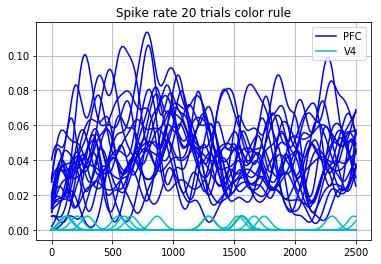

motion rule
X_rule_PFC.shape
(29, 370, 800)
X_rule_V4.shape
(29, 370, 800)


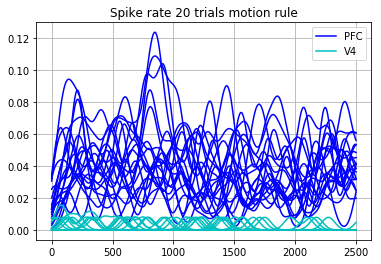

In [20]:
def plot_raw(X_rule, y_rule_elect, electrode, num_trials, rule, time):
    X_rule_PFC = X_rule[y_rule_elect == 'PFC']
    X_rule_V4 = X_rule[y_rule_elect == 'V4']

    print(rule  + ' rule')
    print('X_rule_PFC.shape')
    print(X_rule_PFC.shape)
    print('X_rule_V4.shape')
    print(X_rule_V4.shape)

    #plotting some of the data to see what is going on inside the 
    #plt.plot(X_rule_PFC[0], c='darkorchid')

    for i, trial in enumerate(X_rule_PFC[electrode][:num_trials]):
        plt.plot(time, trial, c='blue', label='PFC' if i == 0 else "")

    for i, trial in enumerate(X_rule_V4[electrode][:num_trials]):
        plt.plot(time, trial, c='c', label='V4' if i == 0 else "")
        
    plt.grid(which='both')
    plt.legend(loc='upper right')
    plt.title('Spike rate ' + str(num_trials) + ' trials ' + rule + ' rule')
    plt.show()

#defining the time vector
time = np.linspace(0, 2500, num=X_motion.shape[2])

neuron = 20
num_trials = 20
rule = 'color'
plot_raw(X_color, y_color_elect, neuron, num_trials, rule, time)

rule = 'motion'
plot_raw(X_motion, y_motion_elect, neuron, num_trials, rule, time)

In [21]:
all_areas = np.unique(y_color_elect) 
#can be motion (share the same number of areas, since they where adquired at the same session)
print(all_areas)

['PFC' 'V4']


In [22]:
area = 'PFC'

In [23]:
#defining the time window to train the model
time_window = 50
#crossvalidation
cv = 5
#folder
model_name = 'svm'
folder = 'spike_analysis_motion_color_cv_' + str(cv) + '_'+ model_name +'_'+ str(time_window) + 'ms_' + session + '_' + area +'/'
if not os.path.exists(folder):
    os.makedirs(folder)

In [24]:
#clf = sklearn.ensemble.ExtraTreesClassifier(n_jobs=-1, n_estimators=50)
# print(clf)
clf = svm.LinearSVC()

In [25]:
#?clf

In [27]:
#using fancy indexing to extract neuron data (and its trails from an area)
print('All area motion shape (neurons x trials x time domain (features))')
print(X_motion.shape)
X_motion_area = X_motion[y_motion_elect == area]
print('Current area motion shape (neurons x trials x time domain (features))')
print(X_motion_area.shape)

All area motion shape (neurons x trials x time domain (features))
(58, 370, 800)
Current area motion shape (neurons x trials x time domain (features))
(29, 370, 800)


In [28]:
#rolling the trials axis first, since we are going to classify motion/color given the trials samples
X_motion_area = np.rollaxis(X_motion_area, 1, 0)
print(X_motion_area.shape)

(370, 29, 800)


In [29]:
#generating the labels for motion from the length of the trials (samples)
y_motion_area = np.repeat(0,int(X_motion_area.shape[0]))
print(np.unique(y_motion_area, return_counts=True))

(array([0]), array([370], dtype=int64))


In [30]:
#color processing

In [31]:
#using fancy indexing to extract electrode data (and its trails from an area)
X_color_area = X_color[y_color_elect == area]
print(X_color_area.shape)

(29, 372, 800)


In [32]:
#rolling the trials axis first
X_color_area = np.rollaxis(X_color_area, 1, 0)
print(X_color_area.shape)

(372, 29, 800)


In [33]:
#generating the labels for color from the length of the trials (samples)
y_color_area = np.repeat(1,int(X_color_area.shape[0]))
print(np.unique(y_color_area, return_counts=True))

(array([1]), array([372], dtype=int64))


In [34]:
'motion and color area shapes'
print(X_motion_area.shape)
print(X_color_area.shape)

(370, 29, 800)
(372, 29, 800)


In [35]:
#concatenating motion and color by the trials
X_motion_color_area = np.concatenate((X_motion_area, X_color_area), axis=0)
print('X_motion_color_area.shape \n(trials x neurons x time domain)')
print(X_motion_color_area.shape)

X_motion_color_area.shape 
(trials x neurons x time domain)
(742, 29, 800)


In [36]:
y_motion_color_area = np.concatenate((y_motion_area, y_color_area))
print(np.unique(y_motion_color_area, return_counts=True))

(array([0, 1]), array([370, 372], dtype=int64))


In [37]:
#split our data array into windows arrays

In [38]:
split_area_windows = np.array_split(X_motion_color_area, X_motion_color_area.shape[2]/time_window, axis=2)

In [39]:
#what has been created?
print('split_area_windows info')
print(type(split_area_windows))
print('length ' + str(len(split_area_windows)))
#iterate over the first five element
for i, window in enumerate(split_area_windows):
    print('element #' + str(i) )
    print(window.shape)

split_area_windows info
<class 'list'>
length 16
element #0
(742, 29, 50)
element #1
(742, 29, 50)
element #2
(742, 29, 50)
element #3
(742, 29, 50)
element #4
(742, 29, 50)
element #5
(742, 29, 50)
element #6
(742, 29, 50)
element #7
(742, 29, 50)
element #8
(742, 29, 50)
element #9
(742, 29, 50)
element #10
(742, 29, 50)
element #11
(742, 29, 50)
element #12
(742, 29, 50)
element #13
(742, 29, 50)
element #14
(742, 29, 50)
element #15
(742, 29, 50)


In [41]:
#defining the time vector
time = np.linspace(50, 2500, num=len(split_area_windows))
print(time)

[  50.          213.33333333  376.66666667  540.          703.33333333
  866.66666667 1030.         1193.33333333 1356.66666667 1520.
 1683.33333333 1846.66666667 2010.         2173.33333333 2336.66666667
 2500.        ]


In [42]:
#modelling
#we have the data ready now for processing in the machine learning algorithms!

#for the modelling results we are interested in the f-score (f1-score) metric
#?f1_score

#we are going to obtian the mean and the standard deviation of the folds f-scores in our modelling part

In [43]:
def cross_validate_clf(split_area_windows, y_motion_color_area, cv, scoring, clf, folder, area):
    color_f_score = []
    motion_f_score = []

    color_f_score_std = []
    motion_f_score_std = []

    j = 0
    for X_window in split_area_windows:
        j = j+1
        print('Window iteration #' + str(j))
        print('window shape of current iteration')
        print(X_window.shape)
        #reshaping the array for samples = trials features = electrodes by time features
        X_window  = np.reshape((X_window), (X_window.shape[0], X_window.shape[1]* X_window.shape[2]))
        #scikit learn function to crossvalidate
        out = cross_validate(clf, X_window, y_motion_color_area, scoring=scoring, cv=cv, return_train_score=False, n_jobs=-1)
        i = 0
        num_elements_cv = len(out)
        #iterating over the dictionary
        for key, value in out.items():
            i = i + 1
            print('crossvalidation  value #' + str(i))
            print(key)
            print(value)
            if i == num_elements_cv-1:
                #calculating the mean of the crossvalidation results
                motion_f_score.append(np.average(value))
                #calculating the standard deviation of the crossvalidated results
                motion_f_score_std.append(np.std(value))
    #             print('motion_f_score')
    #             print(motion_f_score)
            if i == num_elements_cv:
                color_f_score.append(np.average(value))
                color_f_score_std.append(np.std(value))
    #             print('color_f_score')
    #             print(color_f_score)

    #transforming lists to numpy arrays
    motion_f_score = np.array([motion_f_score])
    motion_f_score = motion_f_score[0]

    color_f_score = np.array([color_f_score])
    color_f_score = color_f_score[0]

    motion_f_score_std = np.array([motion_f_score_std])
    motion_f_score_std = motion_f_score_std[0]

    color_f_score_std = np.array([color_f_score_std])
    color_f_score_std = color_f_score_std[0]

    #saving the results of the current modelling for future use (and not need to re run again)
    np.savetxt(folder + area + '_motion_score_' + str(time_window) + 'ms_window.txt', motion_f_score, fmt='%10.5f')
    np.savetxt(folder + area + '_motion_score_std' + str(time_window) + 'ms_window.txt', motion_f_score_std, fmt='%10.5f')

    np.savetxt(folder + area + '_color_score_' + str(time_window) + 'ms_window.txt', color_f_score, fmt='%10.5f')
    np.savetxt(folder + area + '_color_score_std' + str(time_window) + 'ms_window.txt', color_f_score_std, fmt='%10.5f')

    return motion_f_score, color_f_score, motion_f_score_std, color_f_score_std


In [44]:
motion_f_score, color_f_score, motion_f_score_std, color_f_score_std = cross_validate_clf(split_area_windows,
                                                                                          y_motion_color_area, cv,
                                                                                          scoring, clf, folder, area)

Window iteration #1
window shape of current iteration
(742, 29, 50)
crossvalidation  value #1
fit_time
[0.3355186  0.28861332 0.3220284  0.32135248 0.32103062]
crossvalidation  value #2
score_time
[0.         0.         0.00299096 0.0039916  0.00299144]
crossvalidation  value #3
test_f_score motion
[0.5477707  0.49295775 0.375      0.54929577 0.50322581]
crossvalidation  value #4
test_f_score color
[0.4964539  0.53846154 0.40789474 0.58441558 0.45390071]
Window iteration #2
window shape of current iteration
(742, 29, 50)
crossvalidation  value #1
fit_time
[0.35473371 0.46911764 0.37068391 0.42154598 0.42657399]
crossvalidation  value #2
score_time
[0.00398326 0.00299191 0.00302267 0.00698566 0.00694108]
crossvalidation  value #3
test_f_score motion
[0.45517241 0.44117647 0.49006623 0.48684211 0.50340136]
crossvalidation  value #4
test_f_score color
[0.48366013 0.5308642  0.46896552 0.45833333 0.51006711]
Window iteration #3
window shape of current iteration
(742, 29, 50)
crossvalidatio

In [45]:
#sample of the results
print('motion_f_score')
print(motion_f_score)

print('\nList lenght (motion_f_score) ' + str(len(motion_f_score)))

motion_f_score
[0.49365001 0.47533172 0.47858791 0.48928162 0.72526786 0.81026649
 0.78933995 0.80586563 0.78152255 0.72417815 0.6807453  0.67915308
 0.68394787 0.60548241 0.55806217 0.59095076]

List lenght (motion_f_score) 16


In [46]:
#plot for mean and using function fill (in between) in matplotlib for standard deviation

def plot_decoding_results(motion_f_score, color_f_score, motion_f_score_std, color_f_score_std, folder, area):
    plt.plot(time, motion_f_score, label='Motion', marker='.', color='green')
    plt.fill_between(time, motion_f_score - motion_f_score_std, motion_f_score + motion_f_score_std, alpha=0.5, color='green')
    plt.plot(time, color_f_score, label='Color', marker='.', color='magenta')
    plt.fill_between(time, color_f_score - color_f_score_std, color_f_score + color_f_score_std, alpha=0.5, color='magenta')


    # horizontal line to exemplify our chance level
    y_for_chance = np.repeat(0.50, len(split_area_windows))

    plt.plot(time, y_for_chance, '--', c='black')
    plt.ylim([0.4, 1])
    plt.grid(which='both')
    plt.minorticks_on()
    plt.xlabel('Time (ms)')
    plt.legend(loc='upper right')
    plt.ylabel('decoder f-score')

    # show y axis as percentage
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    plt.axvline(x=500, c='black')

    # vertical lines for cue and stimulus
    plt.text(500.1, 0.5, 'Cue', rotation=90)
    plt.text(1500.1, 0.5, 'Stimulus', rotation=90)

    plt.axvline(x=1500, c='black')
    plt.title('Motion and color decoding of area ' + area + '- Spike rate')
    fig = plt.gcf()
    fig.set_size_inches(10, 5)
    fig.savefig(folder + area + '_motion_color_plot.png', format='png')


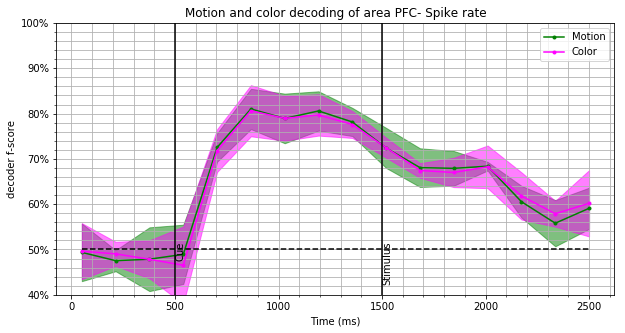

In [47]:
plot_decoding_results(motion_f_score, color_f_score, motion_f_score_std, color_f_score_std, folder, area)

In [48]:
#modelling for V4
areas = np.unique(y_motion_elect)
print(areas)

['PFC' 'V4']


In [49]:
area = 'V4'

In [50]:
time_window = 50
cv = 5
#folder
model_name = 'svm'
folder = 'spike_analysis_motion_color_cv_' + str(cv) + '_'+ model_name +'_'+ str(time_window) + 'ms_' + session + '_' + area +'/'
if not os.path.exists(folder):
    os.makedirs(folder)


In [51]:
clf = sklearn.ensemble.ExtraTreesClassifier(n_jobs=-1, n_estimators=50)
#clf = svm.LinearSVC()
print(clf)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


In [52]:
#we also can do all areas at once with:
#all_areas = np.unique(y_color_elect)
#for area in all_areas:

X_motion_area = X_motion[y_motion_elect == area]
print(X_motion_area.shape)
X_motion_area = np.rollaxis(X_motion_area, 1, 0)
print(X_motion_area.shape)
#generating the labels for motion
y_motion_area = np.repeat(0,int(X_motion_area.shape[0]))
print(np.unique(y_motion_area, return_counts=True))

X_color_area = X_color[y_color_elect == area]
print(X_color_area.shape)
X_color_area = np.rollaxis(X_color_area, 1, 0)
print(X_color_area.shape)
#generating the labels for color
y_color_area = np.repeat(1,int(X_color_area.shape[0]))
print(np.unique(y_color_area, return_counts=True))

#concatenating motion and color by the trials
X_motion_color_area = np.concatenate((X_motion_area, X_color_area), axis=0)
print(X_motion_color_area.shape)
y_motion_color_area = np.concatenate((y_motion_area, y_color_area))
print(np.unique(y_motion_color_area, return_counts=True))


split_area_windows = np.array_split(X_motion_color_area, X_motion_color_area.shape[2]/time_window, axis=2)


#what has been created?
print(type(split_area_windows))
print(len(split_area_windows))

time = np.linspace(100, 2500, num=len(split_area_windows))

(29, 370, 800)
(370, 29, 800)
(array([0]), array([370], dtype=int64))
(29, 372, 800)
(372, 29, 800)
(array([1]), array([372], dtype=int64))
(742, 29, 800)
(array([0, 1]), array([370, 372], dtype=int64))
<class 'list'>
16


In [53]:
motion_f_score, color_f_score, motion_f_score_std, color_f_score_std = cross_validate_clf(split_area_windows,
                                                                                          y_motion_color_area, cv,
                                                                                          scoring, clf, folder, area)

Window iteration #1
window shape of current iteration
(742, 29, 50)
crossvalidation  value #1
fit_time
[0.5956738  0.5516181  0.61129999 0.5956738  0.5935061 ]
crossvalidation  value #2
score_time
[0.         0.00298977 0.         0.         0.0021677 ]
crossvalidation  value #3
test_f_score motion
[0.42857143 0.48684211 0.5060241  0.48366013 0.32075472]
crossvalidation  value #4
test_f_score color
[0.58139535 0.46575342 0.36923077 0.44755245 0.62105263]
Window iteration #2
window shape of current iteration
(742, 29, 50)
crossvalidation  value #1
fit_time
[0.68292975 0.69988251 0.76670718 0.54274178 0.74775481]
crossvalidation  value #2
score_time
[0.00797892 0.0069828  0.00598097 0.01564336 0.00299144]
crossvalidation  value #3
test_f_score motion
[0.34545455 0.39705882 0.54878049 0.51533742 0.34375   ]
crossvalidation  value #4
test_f_score color
[0.61702128 0.49382716 0.43939394 0.40601504 0.5       ]
Window iteration #3
window shape of current iteration
(742, 29, 50)
crossvalidatio

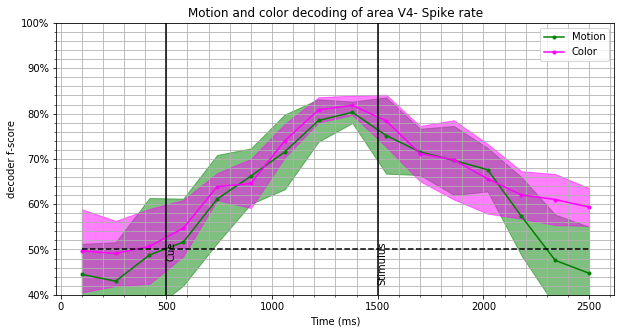

In [54]:
plot_decoding_results(motion_f_score, color_f_score, motion_f_score_std, color_f_score_std, folder, area)